In [1]:
from queryFreeSurferMeasures import *
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Specify the filename
fsDb = "/Users/schabdachj/Data/22q11/fsResults.db"

In [3]:
## Load the freesurfer results as a dataframe

# Connect to the database
cursor, connection = connectToDatabase(fsDb)

# Get a list of ids where one image id is returned per subject
idsStringForQuery, metadataDf = getSingleImageIdPerSubject(cursor)
metadataDf['session_id'] = metadataDf['session_id'].astype(np.int64)
metadataDf = metadataDf.set_index('session_id')

# Get the volumetric metrics for the image ids
measuresDf = getMeasureStatsAsDf(cursor, idsStringForQuery)

# Close the connection to the database
closeDatabase(connection)

# Convert the dataframes to numeric where relevant
for header in list(measuresDf):
    measuresDf[header] = measuresDf[header].astype(float)

measuresDf = measuresDf.infer_objects()

In [4]:
## Join the measures and metadata dataframes on session_id (index, but still need to specify)
mainDf = metadataDf.join(measuresDf, on='session_id')

In [5]:
## Load the subject ages, sexes, year of scan, and scanner
fn = "/Users/schabdachj/Data/22q11/session_metainfo_27Oct2020.csv"

df = pd.read_csv(fn, encoding='latin-1')
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(index=0)
df = df.infer_objects()
cols = ['SUBJECT_ID', 'DeID.GS.bucket.path', 'SEX', 'Year.of.Study', 'OBJECT_INFO...age_at_imaging_.days.', 'DeviceSerialNumber', 'StationName']
sesMetaDf = df[cols].drop_duplicates()

In [6]:
## Get the folders containing each session in the main df

def getPathFromSession(session):
    
    # Get the session as a subdirectory
    sess = session.split('-')[1]
    
    # Use glob to find the possible subject/DeID paths
    searchStr = "/Users/schabdachj/Data/22q11/sourcedata/22q_*/**/GCPDicom*/"+sess
    paths = glob.glob(searchStr, recursive=True)
    
    # Remove bad paths:
    # - Anyting containing GCPDicom 2+ times
    path = [p for p in paths if p.count("GCPDicom") == 1][0]

    
    # Replace the first part of the path with the path that exists locally
    path = "/".join(path.split('/')[:-1])
    path = path.replace('Users/schabdachj/Data/22q11/sourcedata', '22q_dev2020July_DeID')
    
    return path

    
mainDf['DeID.GS.bucket.path'] = [getPathFromSession(ses) for ses in mainDf['session']]

In [7]:
## Join mainDf and sesMetaDf

mainDf = mainDf.reset_index()
mainDf = mainDf.merge(sesMetaDf.reset_index(), on='DeID.GS.bucket.path').dropna()
mainDf.shape

(76, 34)

In [8]:
mainDf

,session_id,subj,session,run,BrainSeg,BrainSegNotVent,BrainSegNotVentSurf,BrainSegVol-to-eTIV,CerebralWhiteMatter,Cortex,...,rhCortex,rhSurfaceHoles,DeID.GS.bucket.path,index,SUBJECT_ID,SEX,Year.of.Study,OBJECT_INFO...age_at_imaging_.days.,DeviceSerialNumber,StationName
0,1,sub-22q0117,ses-1.3.6.1.4.1.11129.5.1.15654686678793006404...,sub-22q0117_ses-1.3.6.1.4.1.11129.5.1.15654686...,1381055.0,1354535.0,1.351953e+06,0.844510,417033.685488,694934.207344,...,348579.402604,109.0,/22q_dev2020July_DeID/22q_0117/2587/GCPDicom_d...,1336,22q_0117,M,2009,2587,35008,MRC35008
1,3,sub-22q0183,ses-1.3.6.1.4.1.11129.5.1.18889088397295553375...,sub-22q0183_ses-1.3.6.1.4.1.11129.5.1.18889088...,1236539.0,1216025.0,1.215688e+06,0.808591,389920.639217,632846.065985,...,318134.766924,79.0,/22q_dev2020July_DeID/22q_0183/2695/GCPDicom_d...,2442,22q_0183,M,2016,2695,67016,CHOPM MR1 Prisma
2,5,sub-22q0166,ses-1.3.6.1.4.1.11129.5.1.25499027249911839948...,sub-22q0166_ses-1.3.6.1.4.1.11129.5.1.25499027...,237109.0,234943.0,2.380547e+05,0.386437,155458.961724,43586.768579,...,21604.772692,150.0,/22q_dev2020July_DeID/22q_0166/7/GCPDicom_deid...,1971,22q_0166,M,2006,7,35008,MRC35008
3,6,sub-22q0147,ses-1.3.6.1.4.1.11129.5.1.22157106672867746976...,sub-22q0147_ses-1.3.6.1.4.1.11129.5.1.22157106...,806220.0,789143.0,7.891877e+05,0.708866,241298.140299,413609.607435,...,205441.712927,388.0,/22q_dev2020July_DeID/22q_0147/372/GCPDicom_de...,1676,22q_0147,M,2005,372,20618,MRC20618
4,7,sub-22q0252,ses-1.3.6.1.4.1.11129.5.1.52674797177416709270...,sub-22q0252_ses-1.3.6.1.4.1.11129.5.1.52674797...,921273.0,904203.0,9.018426e+05,0.824497,307013.597701,443921.009037,...,222761.898332,95.0,/22q_dev2020July_DeID/22q_0252/1918/GCPDicom_d...,4262,22q_0252,M,2015,1918,40156,MRC7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,105,sub-22q0157,ses-1.3.6.1.4.1.11129.5.1.52340988221537486878...,sub-22q0157_ses-1.3.6.1.4.1.11129.5.1.52340988...,1043441.0,1025921.0,1.025412e+06,0.827820,346239.244516,497665.645181,...,248359.812187,36.0,/22q_dev2020July_DeID/22q_0157/4129/GCPDicom_d...,1814,22q_0157,M,2016,4129,46005,CHOPBC MR1 Skyra
78,106,sub-22q0157,ses-1.3.6.1.4.1.11129.5.1.16618444623915294296...,sub-22q0157_ses-1.3.6.1.4.1.11129.5.1.16618444...,993775.0,978093.0,9.777386e+05,0.844035,315292.227401,488782.329320,...,245383.521447,77.0,/22q_dev2020July_DeID/22q_0157/2763/GCPDicom_d...,1791,22q_0157,M,2012,2763,35014,MRC35014
79,108,sub-22q0306,ses-1.3.6.1.4.1.11129.5.1.47209847975238669739...,sub-22q0306_ses-1.3.6.1.4.1.11129.5.1.47209847...,480378.0,473926.0,4.761675e+05,0.442593,326544.807624,94776.659634,...,45203.604313,90.0,/22q_dev2020July_DeID/22q_0306/114/GCPDicom_de...,5337,22q_0306,M,2018,114,46005,CHOPBC MR1 Skyra
81,109,sub-22q0002,ses-1.3.6.1.4.1.11129.5.1.27764857530332066856...,sub-22q0002_ses-1.3.6.1.4.1.11129.5.1.27764857...,1018441.0,988083.0,9.875823e+05,0.744628,391011.833946,437824.481201,...,220414.304936,34.0,/22q_dev2020July_DeID/22q_0002/Radiology/11957...,1,22q_0002,F,2010,11957,35014,MRC35014


# Histograms of Metrics

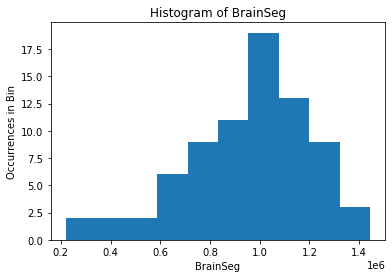

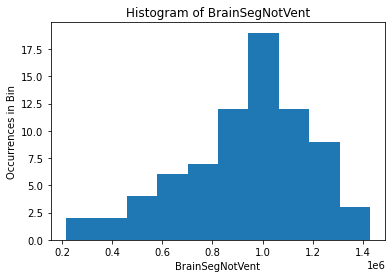

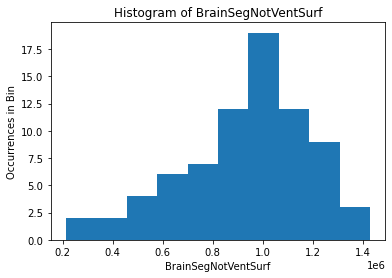

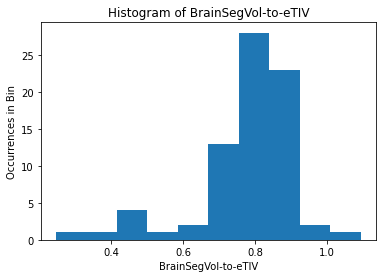

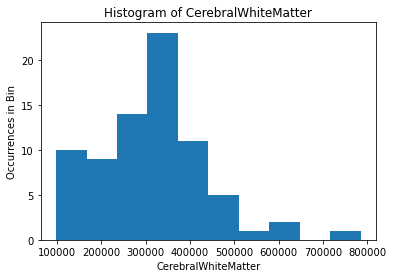

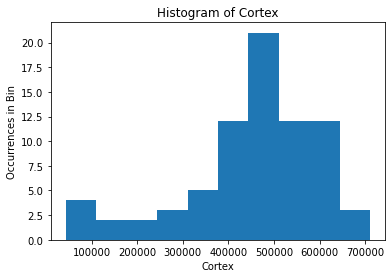

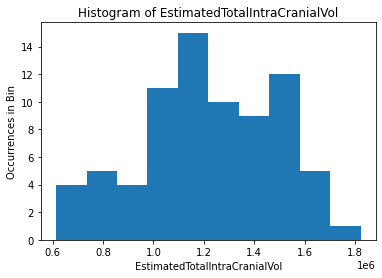

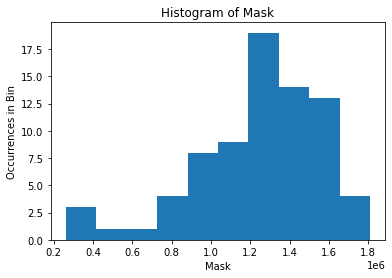

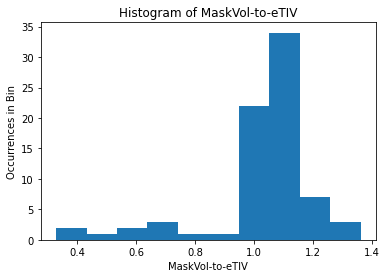

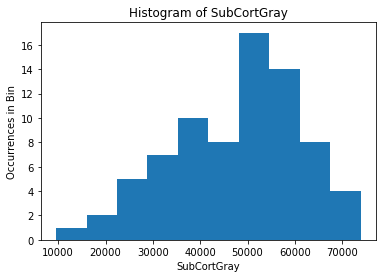

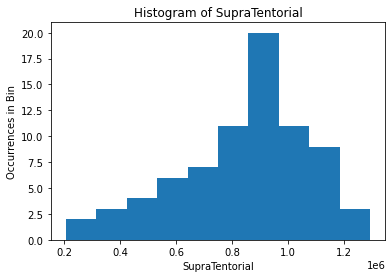

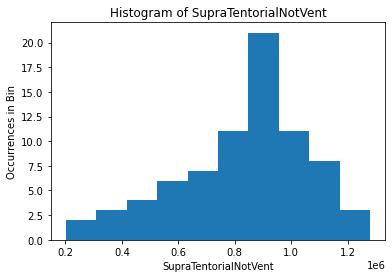

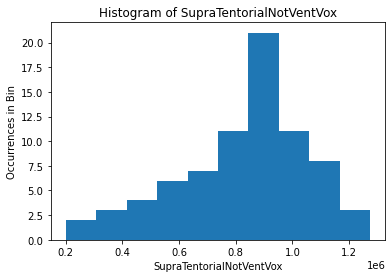

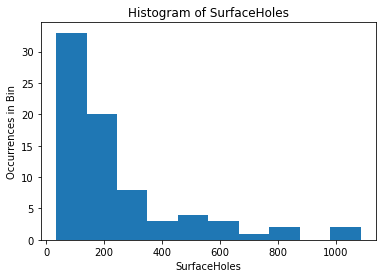

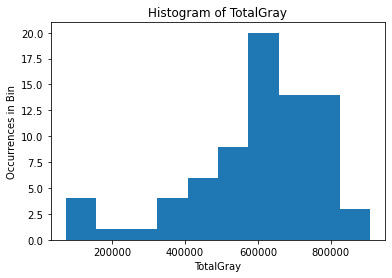

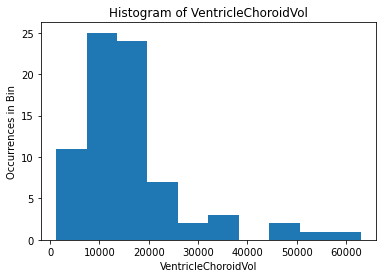

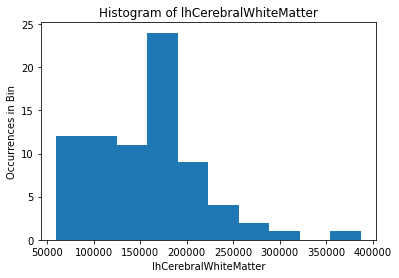

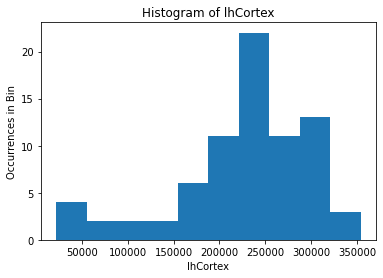

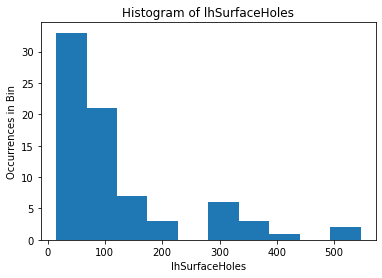

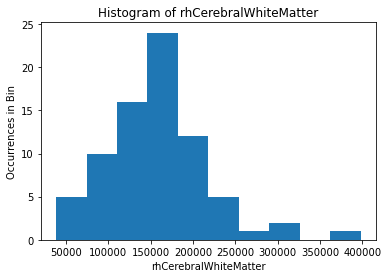

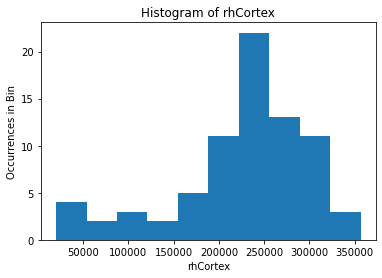

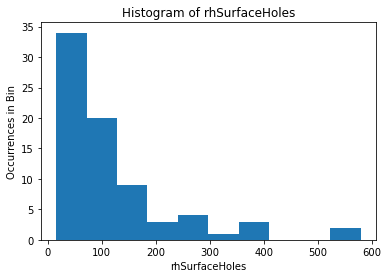

In [9]:
def plotMetricHist(metric, label):
    plt.figure()
    plt.hist(metric)
    plt.title("Histogram of "+label)
    plt.xlabel(label)
    plt.ylabel('Occurrences in Bin')
    plt.show()
        
for c in list(measuresDf):
    plotMetricHist(mainDf[c].astype(float), c)

# Regression: Metric vs. Age at Scan

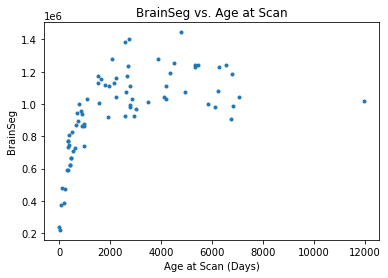

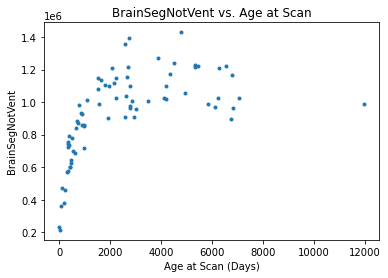

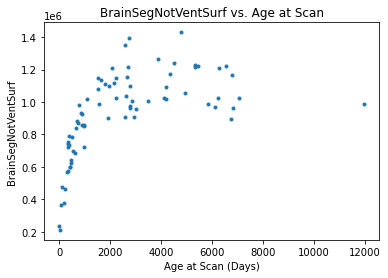

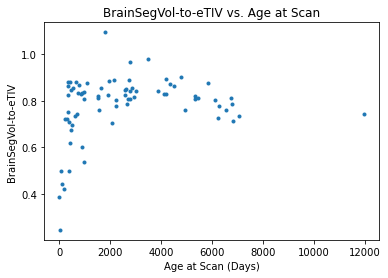

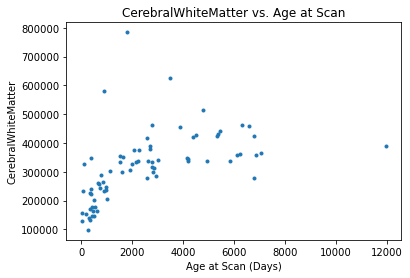

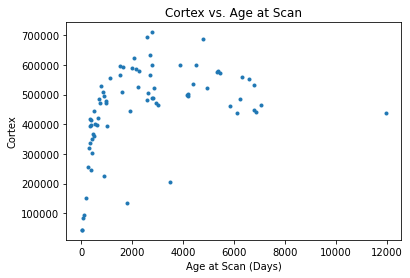

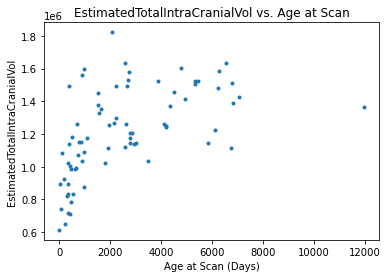

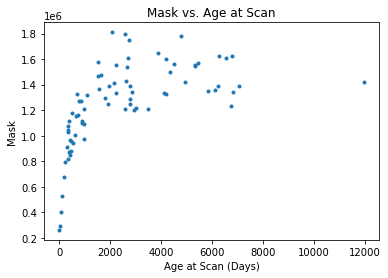

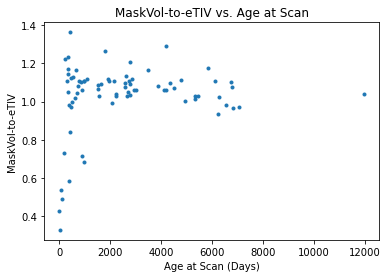

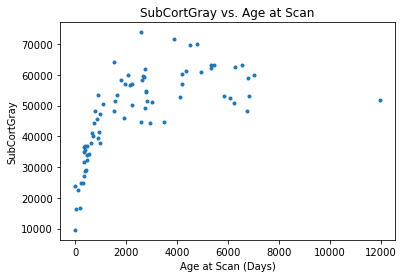

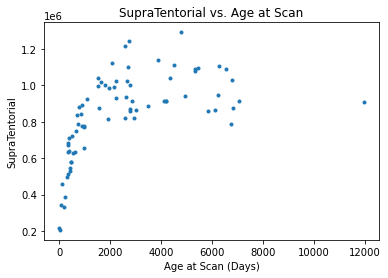

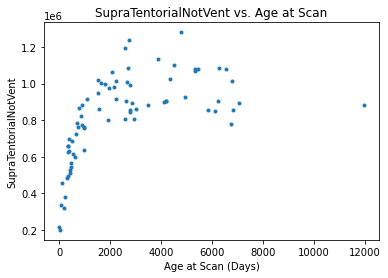

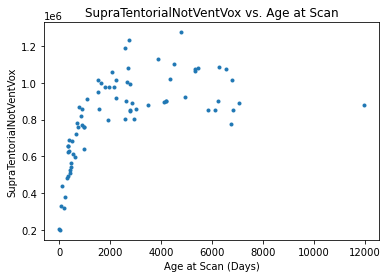

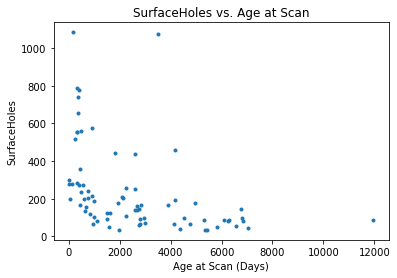

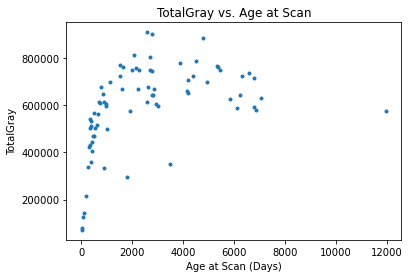

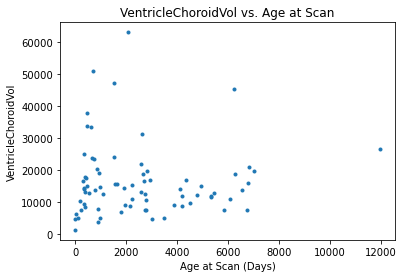

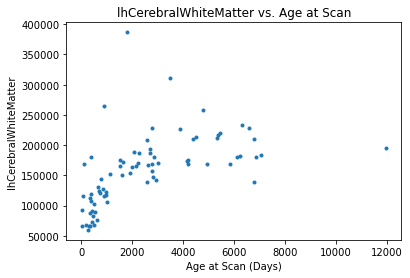

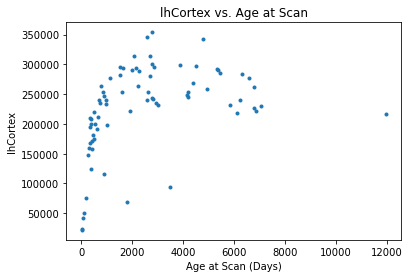

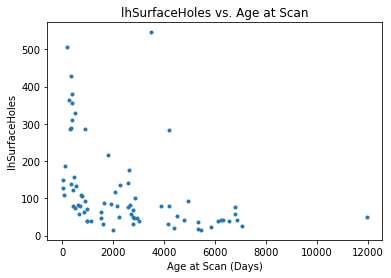

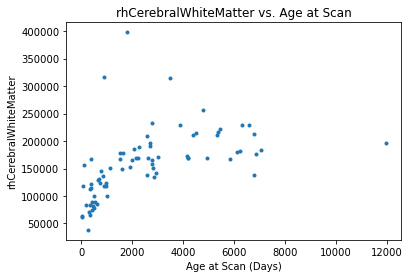

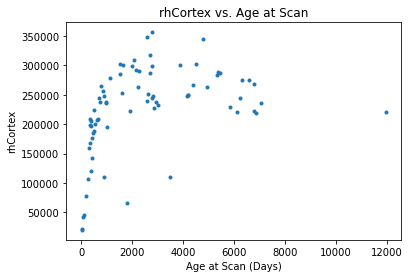

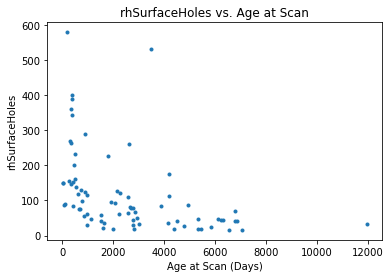

In [10]:
def plotMetricVsAge(metric, age, label):
    plt.figure()
    plt.plot(age, metric, '.')
    plt.title(label+" vs. Age at Scan")
    plt.xlabel("Age at Scan (Days)")
    plt.ylabel(label)
    plt.show()
        
for c in list(measuresDf):
    plotMetricVsAge(mainDf[c].astype(float), mainDf['OBJECT_INFO...age_at_imaging_.days.'], c)

# Looking at scanners

In [11]:
scannerCols = ['DeviceSerialNumber', 'StationName']
mainDf[scannerCols].drop_duplicates().sort_values(by=['DeviceSerialNumber'])


,DeviceSerialNumber,StationName
47,20593,MR5
3,20618,MRC20618
0,35008,MRC35008
36,35014,MRC35014
33,35069,HUP FNDBA MR2
4,40156,MRC7
27,40156,CHOPM MR7 Verio
68,40156,CHOPMMR7Verio
25,40180,MRC40180
18,45195,AWP45195


In [12]:
print(mainDf['DeviceSerialNumber'].drop_duplicates().shape)
mainDf['DeviceSerialNumber'].drop_duplicates()

(12,)


0     35008
1     67016
3     20618
4     40156
11    45195
13    46005
25    40180
33    35069
34    45886
36    35014
47    20593
48    45428
Name: DeviceSerialNumber, dtype: object

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

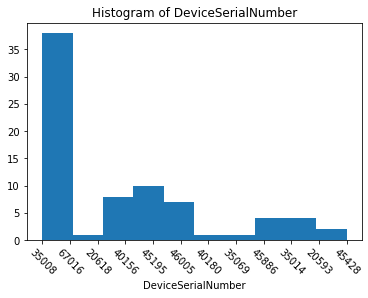

In [13]:
plt.figure()
plt.hist(mainDf['DeviceSerialNumber'])
plt.title('Histogram of DeviceSerialNumber')
plt.xlabel('DeviceSerialNumber')
plt.xticks(rotation=-45)

In [14]:
mainDf['SurfaceHoles'].astype(float).describe()

count      76.000000
mean      238.355263
std       231.361864
min        34.000000
25%        85.000000
50%       162.500000
75%       274.750000
max      1085.000000
Name: SurfaceHoles, dtype: float64

# Example Regression: Brain Volume vs. Age

In [15]:
list(mainDf)

['session_id',
 'subj',
 'session',
 'run',
 'BrainSeg',
 'BrainSegNotVent',
 'BrainSegNotVentSurf',
 'BrainSegVol-to-eTIV',
 'CerebralWhiteMatter',
 'Cortex',
 'EstimatedTotalIntraCranialVol',
 'Mask',
 'MaskVol-to-eTIV',
 'SubCortGray',
 'SupraTentorial',
 'SupraTentorialNotVent',
 'SupraTentorialNotVentVox',
 'SurfaceHoles',
 'TotalGray',
 'VentricleChoroidVol',
 'lhCerebralWhiteMatter',
 'lhCortex',
 'lhSurfaceHoles',
 'rhCerebralWhiteMatter',
 'rhCortex',
 'rhSurfaceHoles',
 'DeID.GS.bucket.path',
 'index',
 'SUBJECT_ID',
 'SEX',
 'Year.of.Study',
 'OBJECT_INFO...age_at_imaging_.days.',
 'DeviceSerialNumber',
 'StationName']

104232.13686138445
0.157208074541893


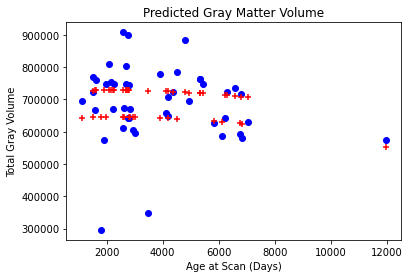

1108
11957
[ 4.53599993e+00 -9.80593951e-04 -8.32660088e+04]


In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import mean_squared_error, r2_score

# Convert SEX column into a dichotomous variable
mainDf['isMale'] = np.where(mainDf['SEX']!= 'M', 1, 0)
mainDf['age2'] = mainDf['OBJECT_INFO...age_at_imaging_.days.']**2

X = mainDf[['OBJECT_INFO...age_at_imaging_.days.', 'age2', 'isMale', 'SurfaceHoles']]
y = mainDf['TotalGray']

X = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095][['OBJECT_INFO...age_at_imaging_.days.', 'age2', 'isMale']] #'SurfaceHoles']]
y = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095]['TotalGray']

# Create an instance of the linear regression model
model = LinearRegression()

# # N-fold cross validation
# cv_results = cross_validate(model, X, y,
#                             scoring=('r2', 'neg_mean_squared_error', 'explained_variance'))

# Split the feature and class pairs intotraining and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the model
model.fit(X, y)

# Test the model
predictions = model.predict(X)

# Compare the predictions to the actual values
# Root mean squared error - lower is better
rmse = (np.sqrt(mean_squared_error(y, predictions)))
# r squared - closer to 1 is better
r2 = r2_score(y, predictions)

print(rmse)
print(r2)

def plotRegressionPredictions(x, y, pred):
    # Plot a figure 
    plt.figure()
    plt.scatter(x, y, c='b')
    plt.scatter(x, predictions, c='r', marker='+')

    # add the regression line
    reg_x = np.linspace(min(x),
                        max(x),
                        x.shape[0]-1)
    # plt.plot(reg_x, reg_x*model.coef_[)

    plt.xlabel('Age at Scan (Days)')
    plt.ylabel('Total Gray Volume')
    plt.title('Predicted Gray Matter Volume')
    plt.show()

    
plotRegressionPredictions(X['OBJECT_INFO...age_at_imaging_.days.'], y, predictions)

print(min(X['OBJECT_INFO...age_at_imaging_.days.']))
print(max(X['OBJECT_INFO...age_at_imaging_.days.']))

print(model.coef_)

In [93]:
peds = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095]
peds[(peds['OBJECT_INFO...age_at_imaging_.days.'] < 4000) & (peds['TotalGray'] < 500000)][['subj', 'SurfaceHoles', 'OBJECT_INFO...age_at_imaging_.days.', 'SEX' ]]

,subj,SurfaceHoles,OBJECT_INFO...age_at_imaging_.days.,SEX
72,sub-22q0211,441.0,1805,F
74,sub-22q0172,1078.0,3490,M


349676.44072
398608.0742520951
0.13993402996021853
0.12275625280271872


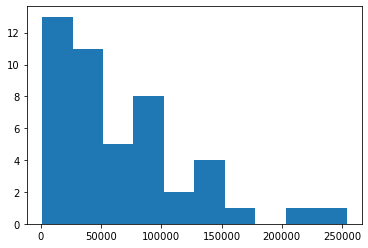

In [92]:
residuals = np.abs(y - predictions)
plt.figure()
plt.hist(residuals)

yq = peds[peds['subj'] == 'sub-22q0172']['TotalGray'].values[0]
print(yq)
idx = list(y.values).index(yq)
resid = (abs(yq-predictions[idx]))
print(predictions[idx])

print(resid/yq)
print(resid/predictions[idx])

In [ ]:
np.multiply